## Finding Arduino Ports
When working with Arduino, it's essential to know which port your Arduino board is connected to on your computer. This is necessary for uploading code and communicating with the board. Each port is identified by a unique name or number, depending on the operating system:

- On Windows, ports are named like `COM3`, `COM4`, etc.
- On macOS and Linux, ports are named like `/dev/ttyUSB0`, `/dev/ttyACM0`, etc.

Run the next cell to know the port number.


In [21]:
import serial.tools.list_ports

def list_all_ports():
    ports = serial.tools.list_ports.comports()

    if not ports:
        print("No serial ports found.")
    else:
        print("Available serial ports:")
        for port in ports:
            print(f"Port: {port.device}, Description: {port.description}")

list_all_ports()

Available serial ports:
Port: COM15, Description: Standard Serial over Bluetooth link (COM15)
Port: COM16, Description: Standard Serial over Bluetooth link (COM16)
Port: COM19, Description: USB Serial Device (COM19)


#### Setup the serial communication with arduino

Change the port value in the next cell with the result that you got in the previous cell

In [22]:
import serial
import time

port = 'COM19' 

ser = serial.Serial(port, 115200)

time.sleep(2)

## Command to read the diode data
Use the following command `m2d` at the next prompt to start recording the diode data. 

Note: To read data from 'csv' file rather from real hardware change the `read_data_from_csv` variable to value `1`.

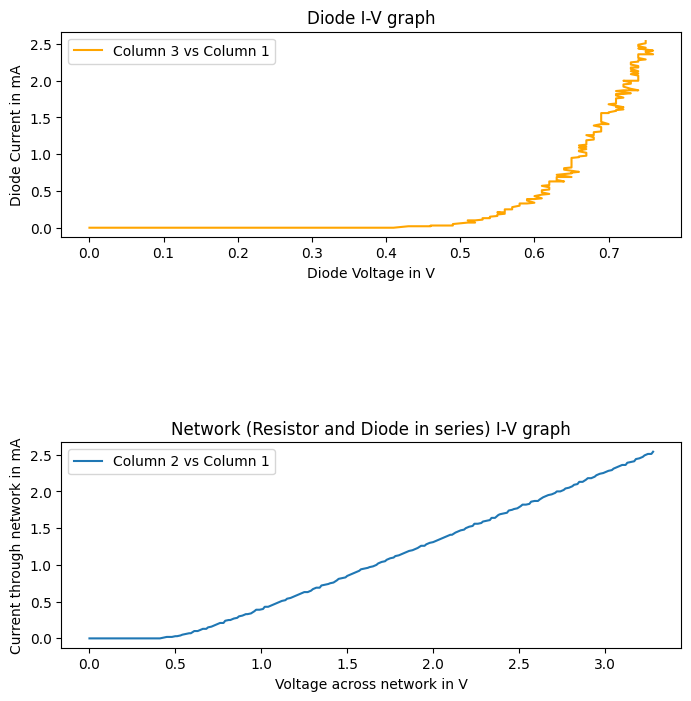

In [2]:
import matplotlib.pyplot as plt
import csv

read_data_from_csv = 0

# Initialize empty lists to store each column
resistor_voltage = []  # Current throught the resistor diode network in mA
dac_voltage = []
diode_voltage = []

if read_data_from_csv == 0:
    print("Type your command:")
    command = input("> ").strip()
    ser.write((command + '\n').encode())
    
    try:
        while True:
            # Read a line of data from the serial port
            if ser.in_waiting > 0:
                line = ser.readline().decode('utf-8').strip()
                
                # Check if the line contains "Ready to enter next command"
                if "Ready to enter next command" in line:
                    print("Received stop command.")
                    break
    
                # Split the line by commas
                values = line.split(',')
                # Check if we received exactly 3 values
                if len(values) == 3:
                    # Append each value to the respective list
                    resistor_voltage.append(float(values[0]))
                    dac_voltage.append(float(values[1]))
                    diode_voltage.append(float(values[2]))
    
                    # Print to verify (optional)
                    # print(f"Col1: {values[0]}, Col2: {values[1]}, Col3: {values[2]}")
    
    except KeyboardInterrupt:
        print("Data collection interrupted.")

else:
    with open('diode_data.csv', mode='r') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            resistor_voltage.append(float(row[0])) 
            dac_voltage.append(float(row[1]))
            diode_voltage.append(float(row[2]))
    


plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)  # 
plt.plot(diode_voltage, resistor_voltage, label='Column 3 vs Column 1', color='orange')
plt.xlabel('Diode Voltage in V')
plt.ylabel('Diode Current in mA')
plt.title('Diode I-V graph')
plt.legend()

plt.subplot(2, 1, 2)  #
plt.plot(dac_voltage, resistor_voltage, label='Column 2 vs Column 1')
plt.xlabel('Voltage across network in V')
plt.ylabel('Current through network in mA')
plt.title('Network (Resistor and Diode in series) I-V graph')
plt.legend()



plt.subplots_adjust(hspace=1)


## Curve Fitting
Note: Before running the next cell make sure that scipy is installed. Following is the command to do: `pip install scipy`

Fitted Parameters: I0 = 2.51e-17 A, n = 4.00


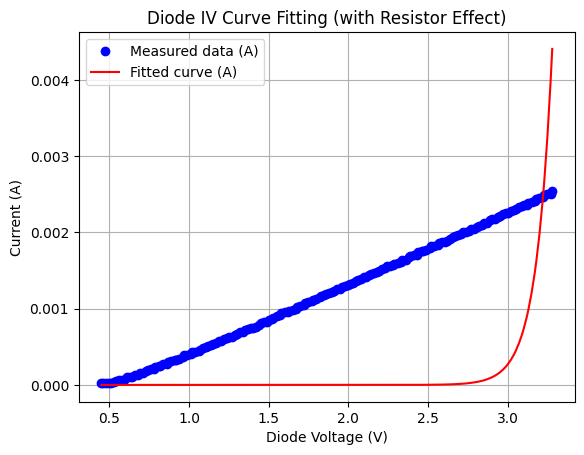

In [3]:
import numpy as np
from scipy.optimize import curve_fit

# Constants
Vt = 0.025  # Thermal voltage at room temperature (in Volts)
R = 1000  # 1kΩ resistor

# Diode equation to fit
def diode_equation(V_diode, I0, n):
    return I0 * (np.exp(V_diode / (n * Vt)) - 1)

def trim_data(voltage, current, voltage_threshold=0.2, current_threshold=0.01):
    """Trim the data to exclude very low voltage and current points."""
    voltage = np.array(voltage)
    current = np.array(current)
    
    # Only keep data where voltage > threshold and current > threshold
    mask = (voltage > voltage_threshold) & (current > current_threshold)
    return voltage[mask], current[mask]

def calculate_diode_voltage(voltage_measured, current):
    """Calculate the diode voltage considering the resistor."""
    # Convert current from mA to A
    current_in_amps = current * 1e-3  # Convert mA to A
    
    # Calculate the diode voltage
    V_diode = voltage_measured 
    return V_diode

def fit_diode_equation(V_diode, current):
    """Fit the diode equation to the data and return the parameters."""
    # Convert current from mA to A
    current_in_amps = current * 1e-3  # Convert mA to A

    # Initial guess for the diode parameters: I0, n
    initial_guess = [1e-12, 1.5]

    # Set bounds to ensure realistic values (I0 > 0, 1 < n < 2)
    bounds = ([1e-20, 1], [1e-7, 4])

    # Perform curve fitting
    popt, pcov = curve_fit(diode_equation, V_diode, current_in_amps, p0=initial_guess, bounds=bounds, maxfev=10000)

    # Extract the fitted parameters
    I0, n = popt
    print(f"Fitted Parameters: I0 = {I0:.2e} A, n = {n:.2f}")

    return popt

def plot_fitted_data(V_diode, current, popt):
    """Plot the fitted curve against the measured data."""
    current_in_amps = current * 1e-3  # Convert mA to A for consistency in plot
    
    # Generate the fitted current from the fitted parameters
    I_fitted = diode_equation(V_diode, *popt)
    
    # Plot the measured and fitted data
    plt.plot(V_diode, current_in_amps, 'bo', label="Measured data (A)")
    plt.plot(V_diode, I_fitted, 'r-', label="Fitted curve (A)")
    plt.xlabel('Diode Voltage (V)')
    plt.ylabel('Current (A)')
    plt.title('Diode IV Curve Fitting (with Resistor Effect)')
    plt.grid(True)
    plt.legend()
    plt.show()

voltage = dac_voltage
current = resistor_voltage

# Trim the data to focus on the forward bias region and ignore small currents
voltage_trimmed, current_trimmed = trim_data(voltage, current, voltage_threshold=0.2, current_threshold=0.01)

# Calculate the diode voltage
V_diode_trimmed = calculate_diode_voltage(voltage_trimmed, current_trimmed)

# Fit the diode equation to the adjusted diode voltage
popt = fit_diode_equation(V_diode_trimmed, current_trimmed)

# Plot the fitted data and the measured data
plot_fitted_data(V_diode_trimmed, current_trimmed, popt)

Fitted Parameters: I0 = 1.00e-07 A, n = 2.94


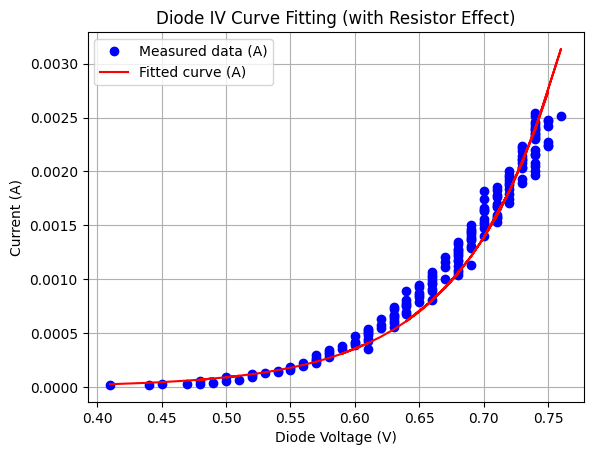

In [34]:
def calculate_diode_voltage(voltage_measured, current):
    """Calculate the diode voltage considering the resistor."""
    # Convert current from mA to A
    current_in_amps = current * 1e-3  # Convert mA to A
    
    # Calculate the diode voltage
    V_diode = voltage_measured - current_in_amps * R 
    return V_diode

voltage = dac_voltage
current = resistor_voltage

# Trim the data to focus on the forward bias region and ignore small currents
voltage_trimmed, current_trimmed = trim_data(voltage, current, voltage_threshold=0.2, current_threshold=0.01)

# Calculate the diode voltage
V_diode_trimmed = calculate_diode_voltage(voltage_trimmed, current_trimmed)

# Fit the diode equation to the adjusted diode voltage
popt = fit_diode_equation(V_diode_trimmed, current_trimmed)

# Plot the fitted data and the measured data
plot_fitted_data(V_diode_trimmed, current_trimmed, popt)